# 1 Package Loading and Preparing

In [116]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import random

# tensorflow for denoising auto-encoder
import tensorflow as tf
from tensorflow.keras import layers, models

# from gluonts.dataset.common import ListDataset
# from gluonts.dataset.util import to_pandas

# from pts.model.deepar import DeepAREstimator
# from pts import Trainer
from sklearn.preprocessing import StandardScaler # to standaridze time series
import yfinance as yf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

In [117]:
## Fetch the Engery Sector SP500 Stocks


axp = yf.Ticker("AXP")
adj_close = axp.history(start = "2020-01-01", end = "2021-12-31")["Close"]

# 2020-2021 two year prices
sp500_index_train = yf.download('^GSPC', start='2020-01-01', end='2021-12-31')["Adj Close"]

# 2022 annual prices, to be predicted
sp500_index_test = yf.download('^GSPC', start='2022-01-01', end='2022-12-31')["Adj Close"]

adj_close = sp500_index_train
adj_close_df = pd.DataFrame(adj_close)
n = adj_close.shape[0]

# Extract adjusted closing prices
print(adj_close_df.head())
print(n)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
              Adj Close
Date                   
2020-01-02  3257.850098
2020-01-03  3234.850098
2020-01-06  3246.280029
2020-01-07  3237.179932
2020-01-08  3253.050049
504


In [118]:
# Time Series Standardization
# from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
adj_close_std_df = adj_close_df.copy()
index_name = adj_close_df.index           # record the index date
columns_name = adj_close_df.columns       # record the column name
columns_to_std = ['Adj Close']            # columns to be standardized


adj_close_std_df[columns_to_std] = pd.DataFrame(
    scaler.fit_transform(adj_close_df[columns_to_std]),   # add back the index
    index = index_name, columns = columns_name)           # add back the column name

print(adj_close_std_df.head())
print(adj_close_df.head())

            Adj Close
Date                 
2020-01-02  -0.797796
2020-01-03  -0.835653
2020-01-06  -0.816840
2020-01-07  -0.831819
2020-01-08  -0.805697
              Adj Close
Date                   
2020-01-02  3257.850098
2020-01-03  3234.850098
2020-01-06  3246.280029
2020-01-07  3237.179932
2020-01-08  3253.050049


# Noise Perturbing

In [134]:
import math
import scipy.stats
import numpy as np
## Forward Markov Chain
## Perturbing noise in the price until totally random

def corrupt(ori_data, beta = None, t = 200):
  """
  Inputs:
    data: A Series
    t: An positive integer
    beta: A list of hyperparameters that control the variance of the noise
          within the range of [0,1] and is non-decreasing
  Output: A Series
  This function addes noise to the stock data and returns this stock data but pertubed
    t times.
  """
  data = ori_data.copy(deep = True)
  #beta = [0.003] * t if beta == None else beta
  beta = np.linspace(0, 0.3, t)

  alpha_bar = 1
  for i in range(t):
    alpha_bar *= 1 - beta[i]
    #alpha.append(1 - beta[i]) # reparameterized by the last hypermeter

  for i in range(len(data)): # pertubing noise n times into each observations of data
    data.iloc[i,0] = math.sqrt(alpha_bar) * data.iloc[i,0] + math.sqrt(1 - alpha_bar) * random.normalvariate(0,1)
  return data


class DiffusionModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(DiffusionModel, self).__init__()
    # Define the architecture using reversible transformations

  def forward(self, x):
    # Implement the forward pass through reversible transformations
    return x

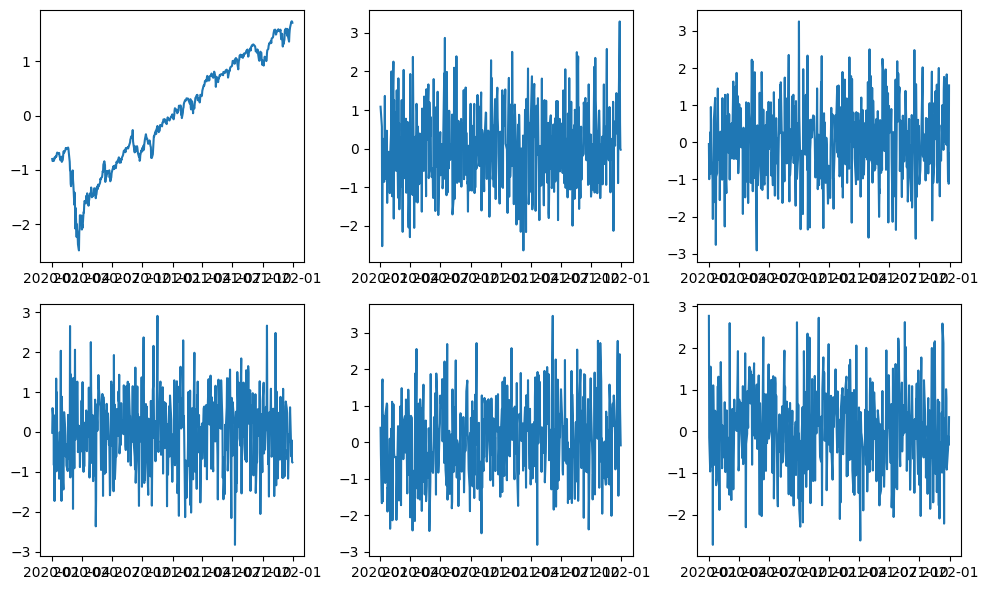

In [135]:
## Demo for the a aaaassaaaaaaaaaa
cor_axp = adj_close_std_df.copy(deep = True)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
fig_count = 0

for time in range(200):# add noise 200 times
  if time in [0, 9, 24, 54, 99, 199]:
    axes[fig_count // 3, fig_count % 3].plot(cor_axp)
    fig_count += 1
  cor_axp = corrupt(cor_axp, t =time) # add noise once

fig.tight_layout()

<Axes: xlabel='Date'>

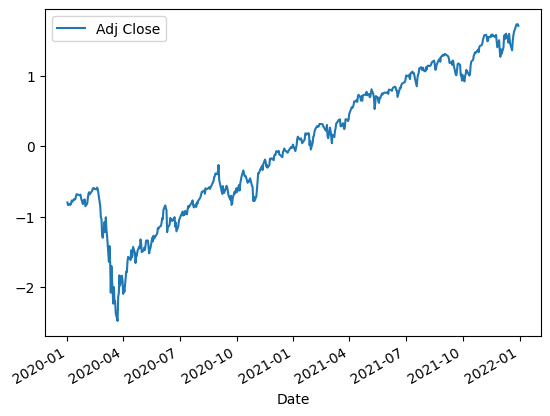

In [121]:
adj_close_std_df.plot()

## Denoising

Need to use Neural Network to calcluate the $\mu_Θ$.

In [139]:
def create_autoencoder(input_dim, encoding_dim):
  """
  This function creates and sets up the architecture for the denoising
    autoencoder using tensorflow.keras.
  Input:
    input_dim: A positive int
    encod_dim: A positive int
  Output:
    An autoencoder ready to denoise a noised data frame.
  """
  hidden_layer_size = 128
  # Define the encoder part of the autoencoder
  encoder_input = layers.Input(shape = (input_dim,))
  encoded = layers.Dense(hidden_layer_size,
                         activation = 'relu')(encoder_input)
  encoded = layers.Dense(encoding_dim,
                         activation = 'relu')(encoded)

  # Define the decoder part of the autoencoder
  decoded = layers.Dense(hidden_layer_size,
                         activation = 'relu')(encoded)
  decoded = layers.Dense(input_dim,
                         activation = 'elu')(decoded)

  # Create the autoencoder model
  return models.Model(encoder_input, decoded)

In [140]:
num_instances = 10      # number of denoised series to be generated
clean_ts_lst = []      # store the clean time series for the autoencoder
noisy_ts_lst = []      # store the noisy time series produced by the autoencoder

original_data = adj_close_std_df

for i in range(num_instances):
  #clean_ts = adj_close_std_df.sample(frac = 1).reset_index(drop = True)
  clean_ts = original_data.copy(deep = True)
  noisy_ts = corrupt(clean_ts, t = 2000) # Add noise to the clean data
  # Store the clean and noisy time series data
  clean_ts_lst.append(clean_ts)
  noisy_ts_lst.append(noisy_ts)

# Convert the lists of time series (each as a DataFrame) to numpy arrays
clean_ts_arr = np.array(clean_ts_lst)
noisy_ts_arr = np.array(noisy_ts_lst)

# Define input and encoding dimensions for the autoencoder
input_dim = clean_ts_arr[0].shape[0]
encoding_dim = clean_ts_arr[0].shape[0]
print(input_dim, encoding_dim)

# Create and train the autoencoder
autoencoder = create_autoencoder(input_dim, encoding_dim)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(noisy_ts_arr, clean_ts_arr, epochs=10, batch_size=32, shuffle=True)

# Generate denoised data using the trained autoencoder
denoised_ts_arr = autoencoder.predict(noisy_ts_arr)

504 504
Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 1.0406
Epoch 2/10
1/1 [==============================] - 0s 8ms/step - loss: 0.9343
Epoch 3/10
1/1 [==============================] - 0s 7ms/step - loss: 0.8571
Epoch 4/10
1/1 [==============================] - 0s 7ms/step - loss: 0.7796
Epoch 5/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6945
Epoch 6/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6084
Epoch 7/10
1/1 [==============================] - 0s 7ms/step - loss: 0.5336
Epoch 8/10
1/1 [==============================] - 0s 7ms/step - loss: 0.4720
Epoch 9/10
1/1 [==============================] - 0s 7ms/step - loss: 0.4125
Epoch 10/10
1/1 [==============================] - 0s 53ms/step


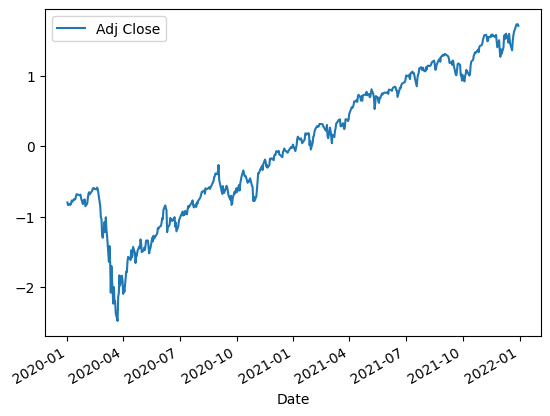

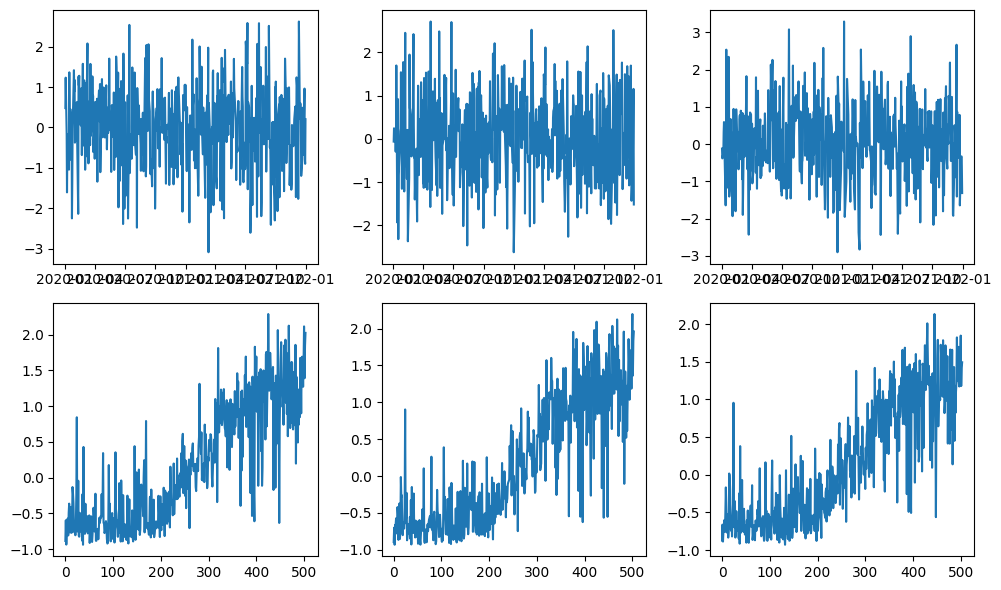

In [141]:
# Demo
adj_close_std_df.plot()
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
for fig_count in range(3):
  axes[0, fig_count % 3].plot(noisy_ts_lst[fig_count])
  axes[1, fig_count % 3].plot(denoised_ts_arr[fig_count])
fig.tight_layout()

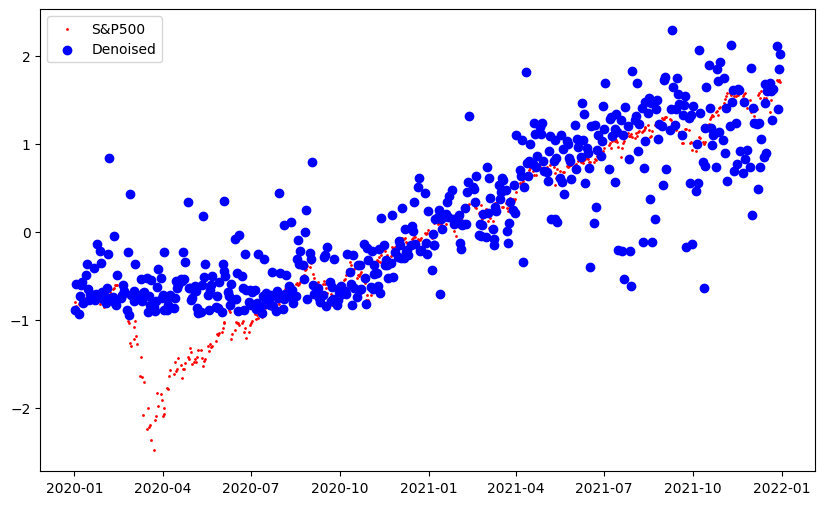

In [149]:
# Plot the clean data (SP500) and the denoised time series together
denoise_df = pd.DataFrame(denoised_ts_arr[0],
                          columns = adj_close_std_df.columns,
                          index = adj_close_std_df.index)
plt.figure(figsize = (10,6))
plt.scatter(adj_close_std_df.index, adj_close_std_df,
            color = 'red', label = 'S&P500', s = 1)
plt.scatter(denoise_df.index, denoise_df, color = 'blue', label = 'Denoised')
plt.legend()
plt.show()


# MLP

# Data Dividing

In [125]:
## Assgined to Yanda
### Could try different time steps  (e.g. 7-day)
### Reference: https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/
# univariate data preparation
# split a univariate sequence into samples
import numpy as np
import pandas as pd

def split_sequence(data, n_steps=30):
  """
    Split a given univariate Series into multiple segments with length equal to steps.
    Input:
        data: A DataFrame
        n_steps: A positive int ; default value = 30
    Output:
        A new data frame that represents the segements of time series
  """
  X, y = [], []
  for i in range(len(data)):
      # find the end of this pattern
      end_ix = i + n_steps
      # check if we are beyond the sequence
      if end_ix > len(data) - 1:
        break
      # gather input and output parts of the pattern
      seq_x, seq_y = data.iloc[i:end_ix], data.iloc[end_ix]
      X.append(seq_x)
      y.append(seq_y)
  return pd.DataFrame(X), pd.DataFrame(y)

# split into samples
X, y = split_sequence(adj_close_std_df)
# summarize the data
print(X.shape, y.shape)
print(X)
print(y)

ValueError: ignored

# New Section

In [ ]:
adj_close_df.shape

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

X, y = split_sequence(adj_close_df)

# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=30))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=2000, verbose=0)

# demonstrate prediction
x_input = np.array(adj_close_df[-n_steps:]).reshape((1, n_steps))
yhat = model.predict(x_input, verbose=0)
print(yhat)